- maven data
    - magnetometer data: [maven.mag.calibrated-pc-1sec](https://pds-ppi.igpp.ucla.edu/search/view/?f=yes&id=pds://PPI/maven.mag.calibrated/data/pc/1sec)
        - 'planetocentric' so we can convert to lon/lat
        - '1sec' because we don't need the higher resolution
    - insitu key parameters: [maven.insitu.calibrated](https://pds-ppi.igpp.ucla.edu/search/view/?f=yes&id=pds://PPI/maven.insitu.calibrated/data)
        - "Spacecraft solar zenith angle: Angle measured from MAVEN to the geometric center of the Sun's disc, as described using a horizontal coordinate system" (column 195)

---
# ~~mag + alt~~

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [38]:
# fin_mag = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\1_raw\maven.mag.calibrated-pc-1sec\2014\10\mvn_mag_l2_2014283pc1s_20141010_v01_r01.sts'
# fin_mag = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\1_raw\maven.mag.calibrated-pc-1sec\2015\01\mvn_mag_l2_2015001pc1s_20150101_v01_r01.sts'

# fin_insitu = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven_mag\raw\maven.insitu.calibrated\mvn_kp_insitu_20150101_v18_r03.tab'

# fin_mag = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven_mag\raw\maven.mag.calibrated-pc-1sec\2015\01\mvn_mag_l2_2015003pc1s_20150103_v01_r01.sts'
# fin_insitu = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven_mag\raw\maven.insitu.calibrated\mvn_kp_insitu_20150103_v18_r03.tab'

fin_mag = r'C:\Users\Eris\Downloads\mvn_mag_l2_2014335pc_20141201_v01_r01.sts'


def find_line_number(filename, string):
    '''return the first line in a file that contains a given string'''

    with open(filename, 'r') as f:
        return next((i for i, line in enumerate(f, start=1) if string in line), None)

    ## The code below is functionally equivalent and easier to read. However, the above uses a generator function instead of a for loop, meaning we don't need to store the whole file in memory at once, thus it's slightly more memory-efficient solution for large files
    # with open(filename, 'r') as f:
    #     for i, line in enumerate(f, start=1):
    #         if string in line:
    #             return i
    # return None

In [39]:
lines_to_skip = find_line_number(fin_mag, '0  0') - 1


dat_mag_cart = np.loadtxt(fin_mag, skiprows=lines_to_skip, usecols=(0,6,7,8,9,11,12,13))
'''columns are initially: 0: year, 1: decimal day of year, 2: BX, 3: BY, 4: BZ, 5: posX, 6: posY, 7: posZ'''

# convert to total decimal days since data collection started, starting with 0 on 2014-10-10 00:00:00
dat_mag_cart[:,1] += (datetime(int(dat_mag_cart[0,0]), 1, 1) - datetime(2014,10,10)).days - 1 


dat_mag_cart = dat_mag_cart[:, [1,5,6,7,2,3,4] ]
'''
`dat_mag_cart` columns are: 
    0: decimal days since 2014-10-10 00:00:00
    1: posX [km]
    2: posY [km]
    3: posZ [km]
    4: BX   [nt]
    5: BY   [nt]
    6: BZ   [nt]
'''



# pre-compute useful values
xy2 = dat_mag_cart[:,1]**2 + dat_mag_cart[:,2]**2              # xy2 = x^2 + y^2
r2 = xy2 + dat_mag_cart[:,3]**2                                # r2  = x^2 + y^2 + z^2

length1 = dat_mag_cart.shape[0]

# altitude cut
max_altitude = 200
i_altitude_cut = np.where(r2 < ((3396.2+max_altitude)**2))[0]
dat_mag_cart = dat_mag_cart[i_altitude_cut,:]
xy2 = xy2[i_altitude_cut]
r2 = r2[i_altitude_cut]

length2 = dat_mag_cart.shape[0]
print(f'Percent reduction: {(length1-length2)/length1*100:.2f}%')


'''
DESCRIPTION
------------
    Convert cartesian to spherical coordinates. 

NOTES
------------
    ORTHOGONALITY: 
        - Position conversion requires simple trig, but magnetic field vectors must be converted with a transformation matrix `D` in order to preserve orthogonality. 
        - Orthogonality is important in this case because it means that the transformation between Cartesian and spherical coordinates maintains both the direction and magnitude of the vectors. In other words, vectors that were orthogonal in the Cartesian coordinate system will remain orthogonal in the spherical coordinate system. 

    COORDINATES:
        - `theta` is the counterclockwise angle in the x-y plane measured in radians from the positive x-axis. The value of the angle is in the range [-pi pi].
        - `phi` is the elevation angle in radians from the x-y plane. The value of the angle is in the range [-pi/2, pi/2].
        - `r` is the elevation angle in radians from the x-y plane. The value of the angle is in the range [-pi/2, pi/2].
    (These make it so our transformation matrix is a bit different from the one on Wikipedia: https://en.wikipedia.org/wiki/Vector_fields_in_cylindrical_and_spherical_coordinates)

'''

dat_mag_sph = np.empty_like(dat_mag_cart)

dat_mag_sph[:,0] = dat_mag_cart[:,0]                                   # decimal day
theta = np.arctan2(dat_mag_cart[:,2], dat_mag_cart[:,1])               # theta = atan2(y,x)
phi   = np.arctan2(dat_mag_cart[:,3], np.sqrt(xy2))                    # phi = atan2(z,sqrt(x^2+y^2))

# precompute values
sin_theta = np.sin(theta)
sin_phi   = np.sin(phi)
cos_theta = np.cos(theta)
cos_phi   = np.cos(phi)

# transformation matrix
D = np.array([
    [ cos_theta * cos_phi  ,      sin_theta * cos_phi  ,       sin_phi              ],
    [ -sin_theta           ,      cos_theta            ,       np.zeros_like(theta) ],
    [ -cos_theta * sin_phi ,      -sin_theta * sin_phi ,       cos_phi              ]
])

# transform magnetic field vectors
dat_mag_sph[:,4:] = np.einsum('ijk,kj->ki', D, dat_mag_cart[:,4:])     # B_theta, B_phi, B_r

# convert to longitude and latitude (degrees)
dat_mag_sph[:,1:3] = np.degrees(np.array([theta, phi]).T)              # lon, lat
dat_mag_sph[:,3] = np.sqrt(r2)                                         # r (elevation)

'''
`dat_mag_cart` columns are: 
    0: decimal days since 2014-10-10 00:00:00
    1: longitude [-180, 180]
    2: latitude  [-90, 90]
    3: elevation [km]
    4: B_theta   [nt]
    5: B_phi     [nt]
    6: B_r       [nt]
'''

print()

Percent reduction: 96.38%



In [40]:
for i in dat_mag_sph[0]:
    print(i)

52.015466887
-69.4667239298792
73.42623241306282
3596.1920032765215
-3.9254594685540005
-1.3437781350245153
2.2870129611722314


### scrap

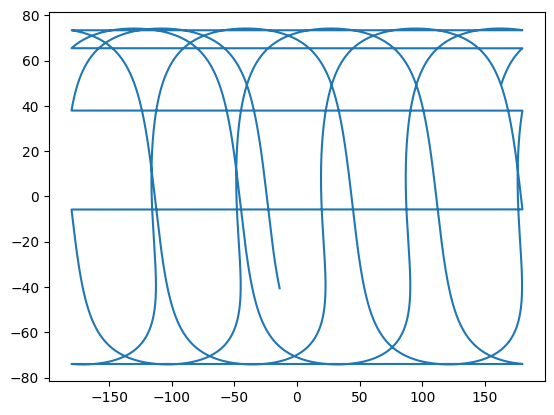

In [258]:
plt.plot(dat_mag_sph[:,1], dat_mag_sph[:,2])
# length = 20_000
# for i in range(0, dat_mag_sph.shape[0], length):
#     plt.plot(dat_mag_sph[i:i+length,5], dat_mag_sph[i:i+length,6])
#     plt.show()

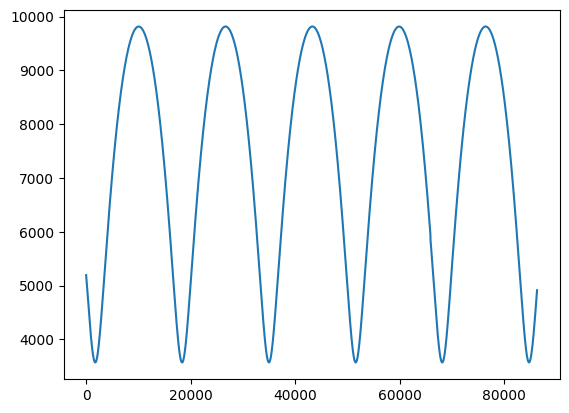

In [259]:
plt.plot(dat_mag_sph[:,3])

---
# ~~actually reduce files~~

see maven_reducer.py

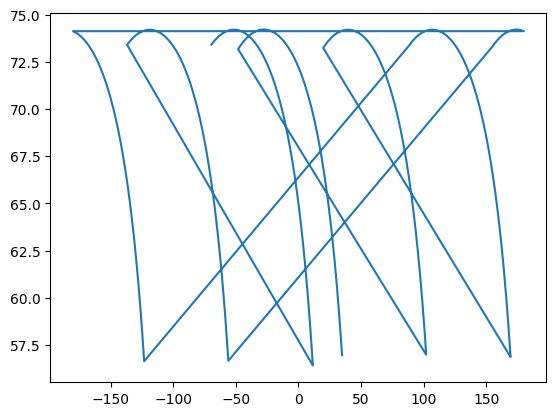

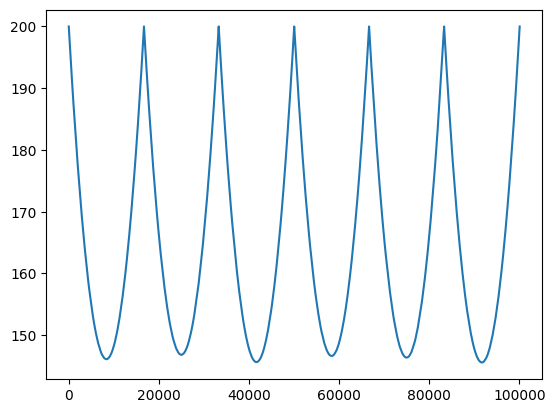

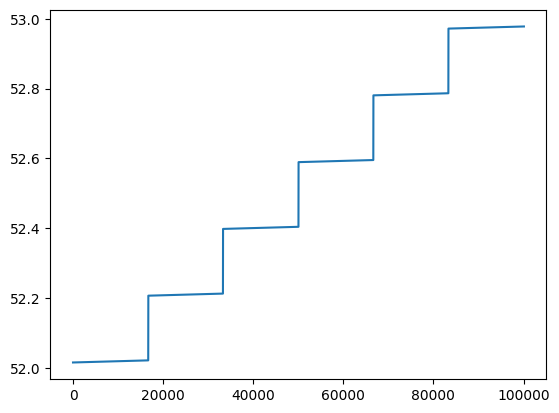

In [41]:
'''from raw file and code at beginning'''

import numpy as np
import matplotlib.pyplot as plt

plt.plot(dat_mag_sph[:,1], dat_mag_sph[:,2])
plt.show()
plt.plot(dat_mag_sph[:,3]-3396.2)
plt.show()
plt.plot(dat_mag_sph[:,0])
plt.show()

from_raw = np.copy(dat_mag_sph)

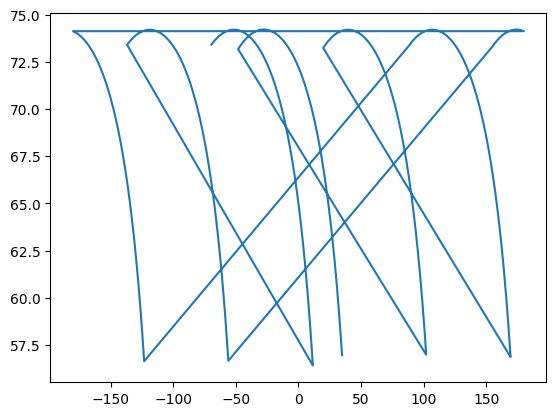

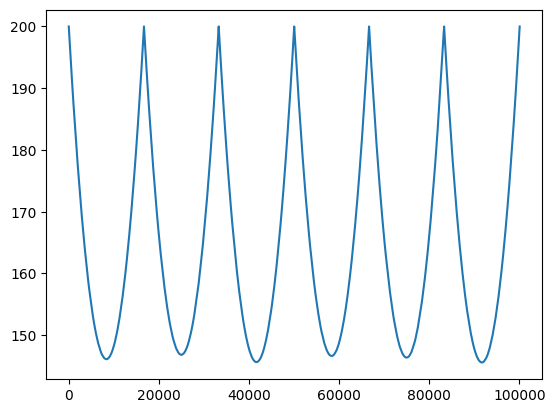

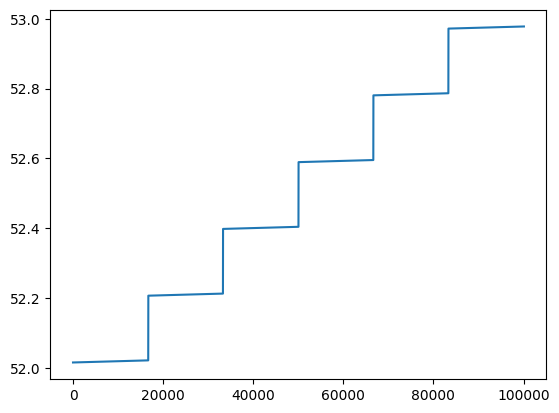

In [42]:
'''from reduced file'''

import numpy as np
import matplotlib.pyplot as plt

dat_mag_sph = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\2014\12\mvn_mag_200km_2014-12-01.npy'

dat_mag_sph = np.load(dat_mag_sph)

plt.plot(dat_mag_sph[:,1], dat_mag_sph[:,2])
plt.show()
plt.plot(dat_mag_sph[:,3]-3396.2)
plt.show()
plt.plot(dat_mag_sph[:,0])
plt.show()

from_reduced = np.copy(dat_mag_sph)

In [43]:
np.allclose(from_raw, from_reduced)

True

### scrap

---
# ~~sza prototype~~

the goal here is to produce an Nx2 array, where each row (pair) are decimal days since data collection started (2014-10-10) which indicate the start and end of nighttime. save this to a text file. it'd also be nice to append sza values to the .npy data file.

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

fin_insitu = r'C:\Users\Eris\Downloads\mvn_kp_insitu_20141010_v18_r03.tab'
# fin_insitu = r'C:\Users\Eris\Downloads\mvn_kp_insitu_20150101_v18_r03.tab'
# fin_insitu = r'C:\Users\Eris\Downloads\mvn_kp_insitu_20180101_v18_r03.tab'

dat_insitu = pd.read_csv(fin_insitu, comment='#', header=None, sep='\s+', usecols=(0,195-1), names=('time','sza'))

dat_sza = dat_insitu['sza'].to_numpy()

''' edge cases
# dat_sza = dat_sza[102:]
# dat_sza = dat_sza[103:]

# dat_sza = dat_sza[:796]
# dat_sza = dat_sza[:797]
'''

night_indices = []

if (dat_sza[0] >= 90 and dat_sza[1] >= 90): # starting in nightside
    night_indices.append(0)

for i in range(1, dat_sza.shape[0]-2):
    if (dat_sza[i] >= 90 and dat_sza[i+1] < 90): # going from nightside to dayside
        night_indices.append(i)
    elif (dat_sza[i] < 90 and dat_sza[i+1] >= 90): # going from dayside to nightside
        night_indices.append(i+1)

if (dat_sza[-1] >= 90 and dat_sza[-2] >= 90): # ending in nightside
    night_indices.append(dat_sza.shape[0]-1)

# print(night_indices)
# print(dat_sza[night_indices])

dat_insitu = dat_insitu.loc[night_indices]


night_range = dat_insitu['time'].tolist()

for i in range(len(night_range)):
    # convert to datetime object
    night_range[i] = datetime.strptime(night_range[i], '%Y-%m-%dT%H:%M:%S')
    # convert to timedelta after data collection started on since 2014-10-10 00:00:00
    night_range[i] = night_range[i] - datetime(2014,10,10)
    # convert to decimal days
    night_range[i] = night_range[i].total_seconds() / (60 * 60 * 24)

night_range = np.array(night_range).reshape(-1,2)

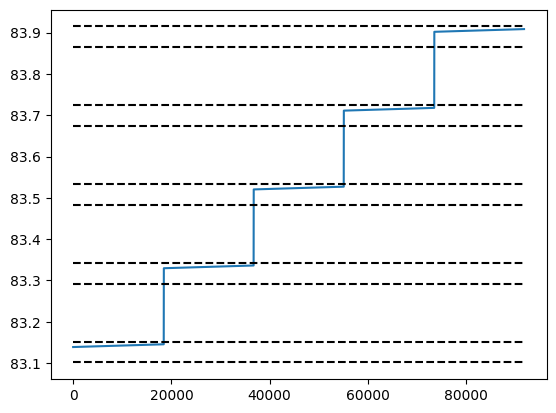

In [382]:
fin_mag = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\2015\01\mvn_mag_200km_2015-01-01.npy'

dat_mag = np.load(fin_mag)

plt.plot(dat_mag[:,0]) 
for i in night_range:
    plt.plot([0,dat_mag.shape[0]],[i,i], 'k--')

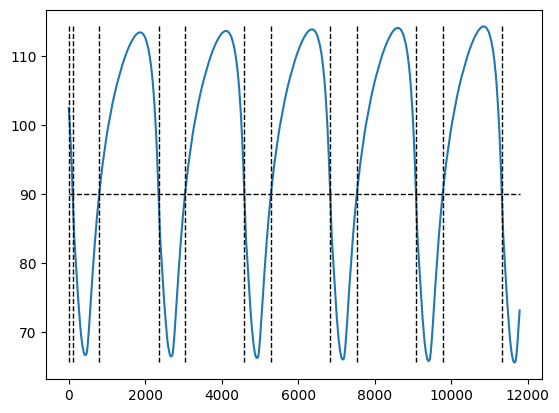

In [319]:
plt.plot(dat_sza)
plt.plot([0, dat_sza.shape[0]], [90, 90], 'k--', lw=1)

for i in night_indices:
    plt.plot([i, i], [dat_sza.max(), dat_sza.min()], 'k--', lw=1)

---
# ~~sza test 2, zipping~~

todo, add random walk. also, make it so we're modifying the array in place most likely...

In [402]:
from redplanet import utils

import zipfile
# import os
import io
from datetime import datetime

import pandas as pd
import numpy as np


min_sza = 90


dirpath__altreduced = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km'

fpath__insituzip    = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\1_raw\maven.insitu.calibrated.zip'

# year = 2014
# month = 10
# day = 10
# year = 2015
# month = 11
# day = 21
# year = 2014
# month = 11
# day = 4
year = 2018
month = 3
day = 22


with zipfile.ZipFile(fpath__insituzip, 'r') as insituzip:
    
    fname__insitu = f'{year}/{month:02}/mvn_kp_insitu_{year}{month:02}{day:02}_v18_r03.tab'

    # sometimes it's 'v13' instead of 'v18', or some other small difference -- this shouldn't happen after 2014/10/10 (start of mag data collection), but we include this just in case
    if fname__insitu not in insituzip.namelist(): 
        phrase_match = f'{year}/{month:02}/mvn_kp_insitu_{year}{month:02}{day:02}'
        fname__insitu = [fname for fname in insituzip.namelist() if (phrase_match in fname and '.tab' in fname)]

        if not fname__insitu:
            print('fuck')
        else:
            fname__insitu = fname__insitu[0]


    with insituzip.open(fname__insitu) as fin_insitu:
        fin_insitu = io.TextIOWrapper(fin_insitu)

        dat_insitu = pd.read_csv(fin_insitu, comment='#', header=None, sep='\s+', usecols=(0,195-1), names=('time','sza'))

        dat_sza = dat_insitu['sza'].to_numpy()

        night_indices = []

        if (dat_sza[0] >= min_sza): # starting in nightside
            night_indices.append(0)

        for i in range(0, dat_sza.shape[0]-1):
            if (dat_sza[i] >= min_sza and dat_sza[i+1] < min_sza): # going from nightside to dayside
                night_indices.append(i)
            elif (dat_sza[i] < min_sza and dat_sza[i+1] >= min_sza): # going from dayside to nightside
                night_indices.append(i+1)

        if (dat_sza[-1] >= min_sza): # ending in nightside
            night_indices.append(dat_sza.shape[0]-1)


        dat_insitu = dat_insitu.loc[night_indices]


        night_range = dat_insitu['time'].tolist()

        for i in range(len(night_range)):
            # convert to datetime object
            night_range[i] = datetime.strptime(night_range[i], '%Y-%m-%dT%H:%M:%S')
            # convert to timedelta after data collection started on since 2014-10-10 00:00:00
            night_range[i] = night_range[i] - datetime(2014,10,10)
            # convert to decimal days
            night_range[i] = night_range[i].total_seconds() / (60 * 60 * 24)

        night_range = np.array(night_range).reshape(-1,2)

    
    dat_mag = np.load(utils.getPath(dirpath__altreduced, year, f'{month:02}', f'mvn_mag_200km_{year}-{month:02}-{day:02}.npy'))

    night_mask = np.zeros_like(dat_mag[:,0], dtype=bool)
    for start, stop in night_range:
        night_mask = np.logical_or(night_mask, np.logical_and(dat_mag[:,0] >= start, dat_mag[:,0] <= stop))

    dat_mag = dat_mag[night_mask]

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Eris\\Documents\\sync_local\\00_Local\\mars\\data\\maven\\2_reduced\\maven.mag.calibrated-pc-highres__filters=200km\\2015\\01\\mvn_mag_200km_2015-01-01.npy'

In [356]:
['s' for s in ''] == []

True

[[25.         25.        ]
 [25.07259259 25.19194444]
 [25.26472222 25.38384259]
 [25.45685185 25.57578704]
 [25.64907407 25.76773148]
 [25.8412037  25.95962963]]
[90.18 89.98 89.77 ... 61.12 61.23 61.33]


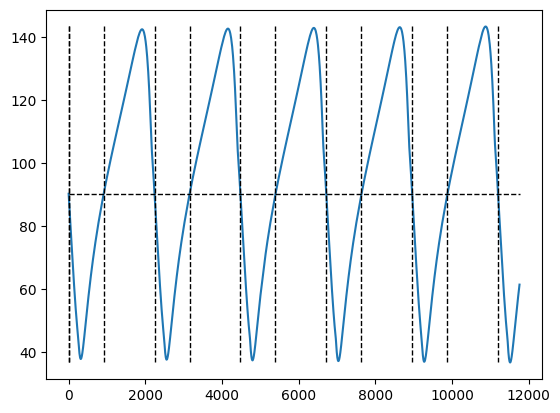

In [342]:
print(night_range)
print(dat_sza)

plt.plot(dat_sza)
plt.plot([0, dat_sza.shape[0]], [90, 90], 'k--', lw=1)

for i in night_indices:
    plt.plot([i, i], [dat_sza.max(), dat_sza.min()], 'k--', lw=1)

---
### mask

(91781, 7)


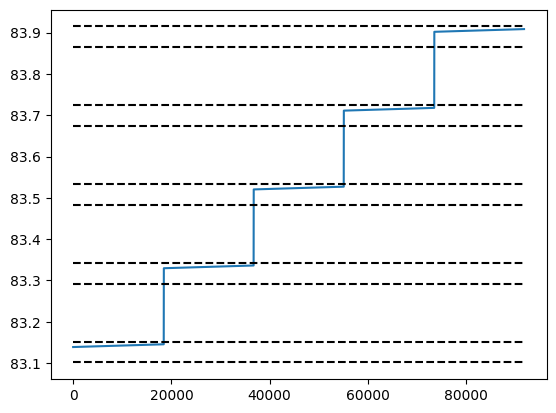

In [305]:
import matplotlib.pyplot as plt

plt.plot(dat_mag[:,0])
for i in (night_range.flatten()):
    plt.plot([0, dat_mag[:,0].shape[0]], [i, i], 'k--')

print(dat_mag.shape)

In [220]:
night_mask = np.zeros_like(dat_mag[:,0], dtype=bool)
for start, stop in night_range:
    night_mask = np.logical_or(night_mask, np.logical_and(dat_mag[:,0] >= start, dat_mag[:,0] <= stop))

dat_mag2 = dat_mag[night_mask]

(96652, 7)


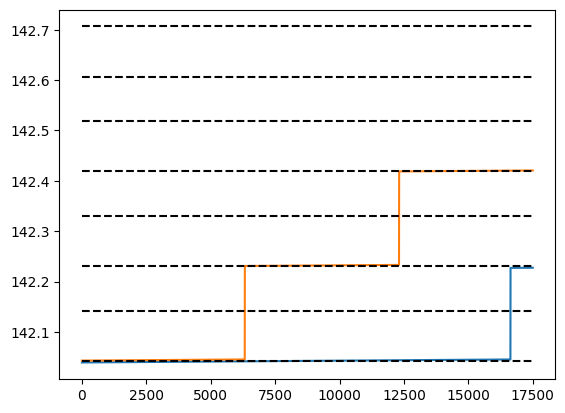

In [228]:
import matplotlib.pyplot as plt

plt.plot(dat_mag[:17500,0])
plt.plot(dat_mag2[:17500,0])

# for i in (night_range.flatten()):
for i in (night_range.flatten()[:-4]):
    # plt.plot([0, dat_mag[:,0].shape[0]], [i, i], 'k--')
    plt.plot([0, 17500], [i, i], 'k--')

print(dat_mag.shape)

In [232]:
print(night_range)
dat_mag[:15000, 0]

[[142.04305556 142.14175926]
 [142.23087963 142.33009259]
 [142.41865741 142.51824074]
 [142.60643519 142.70638889]
 [142.79435185 142.89490741]
 [142.98231481 142.99990741]]


array([142.03932622, 142.03932657, 142.03932694, ..., 142.04475046,
       142.04475082, 142.04475118])

In [142]:
print(night_range)
print()
print(dat_mag[:,0])
print()
print(dat_mag[:,0].shape)

[[89.02287037 89.06861111]
 [89.21388889 89.25944444]
 [89.40472222 89.45018519]
 [89.59555556 89.64092593]
 [89.78648148 89.83166667]
 [89.97722222 89.99990741]]

[89.05369831 89.05369868 89.05369904 ... 89.82321116 89.82321152
 89.82321189]

(95150,)


In [206]:
night_mask.any()

True

In [207]:
night_mask

array([False, False, False, ...,  True,  True,  True])

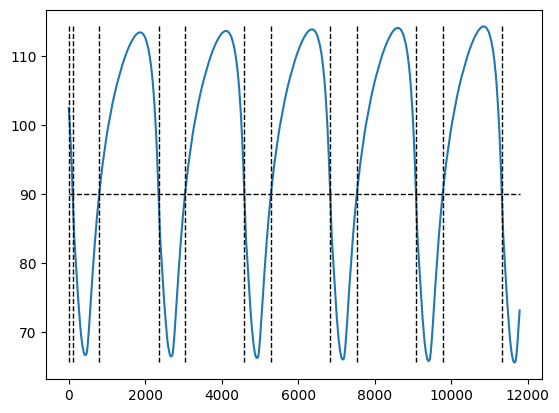

In [316]:
plt.plot(dat_sza)
plt.plot([0, dat_sza.shape[0]], [90, 90], 'k--', lw=1)

for i in night_indices:
    plt.plot([i, i], [dat_sza.max(), dat_sza.min()], 'k--', lw=1)

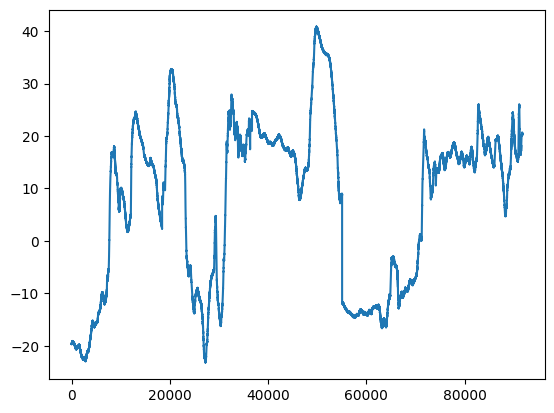

In [251]:
# plt.plot(dat_mag[:,1], dat_mag[:,2])
plt.plot(dat_mag[:,6])

In [272]:
import os

dirpath__altreduced = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km'

# # path = "."
# for root, d_names, f_names in os.walk(dirpath__altreduced):
#    print(root, d_names, f_names)


for root, dirs, fnames in os.walk(dirpath__altreduced):
    for fname in fnames:
        if fname.endswith(".npy"):
            print(utils.getPath(root, fname))

C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\2014\10\mvn_mag_200km_2014-10-10.npy
C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\2014\10\mvn_mag_200km_2014-10-11.npy
C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\2014\10\mvn_mag_200km_2014-10-12.npy
C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\2014\10\mvn_mag_200km_2014-10-13.npy
C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\2014\10\mvn_mag_200km_2014-10-14.npy
C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\2014\10\mvn_mag_200km_2014-10-15.npy
C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.

In [276]:
x = utils.getPath(root, fname)

print(x)
print(os.path.dirname(x))

C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\logs\log__230731-1430__file=maven.mag.calibrated-pc-highres__2023.txt
C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\logs


In [297]:
fpath__mag = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km\2014\10\mvn_mag_200km_2014-10-30.npy'

year = int(fpath__mag[-14:-10])
month = int(fpath__mag[-9:-7])
day = int(fpath__mag[-6:-4])

print(year, month, day)

print(os.path.basename(fpath__mag))

2014 10 30
mvn_mag_200km_2014-10-30.npy


In [295]:
x = r'C:\Users\Eris\Documents\sync_local\00_Local\mars'

x = utils.getPath(x)

utils.getPath(x, 'ff')

'C:\\Users\\Eris\\Documents\\sync_local\\00_Local\\mars\\ff'

In [309]:
dirpath_mvn = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km'



'200'

---
# loc sorting

In [418]:
import numpy as np
import matplotlib.pyplot as plt



'''get maven data'''

dirpath_mvn = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km,sza90'

fpaths_mvn = []
for root, dirs, fnames in os.walk(dirpath_mvn):
    for fname in fnames:
        if fname.endswith('.npy'):
            fpaths_mvn.append(utils.getPath(root, fname))



for i_fpath_maven, fpath_maven in enumerate(fpaths_mvn):

    dat_mvn = np.load(fpath_maven)

    if np.isin(dat_mvn[:,1], -180.0).any():
        print('found -180.0')
    if np.isin(dat_mvn[:,1], 180.0).any(): 
        print('found 180.0')

    if np.isin(dat_mvn[:,2], -90.0).any():
        print('found -90.0')
    if np.isin(dat_mvn[:,2], 90.0).any():
        print('found 90.0')

    # if np.isin(dat_mvn[:,1], 0.0).any():
    #     print('found 0')

found 180.0
found 180.0
found 180.0
found 180.0
found 180.0
found 180.0
found 180.0
found 180.0
found 180.0
found 180.0
found 180.0


---
### scrap

In [447]:
import numpy as np
import matplotlib.pyplot as plt


'''get henry crater info'''
from redplanet import Craters
from redplanet import utils

thiscrater = Craters.get('henry')
# thiscrater = Craters.get('newton')
lon, lat, rad = thiscrater['lon'], thiscrater['lat'], utils.km2theta(thiscrater['diameter_km']/2)
scaling = 5
lon_bounds = (lon-rad*scaling, lon+rad*scaling)
lat_bounds = (lat-rad*scaling, lat+rad*scaling)

# lon_bounds = (22, 25)
# lat_bounds = (0, 20)


'''get maven data'''

dirpath_mvn = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km'
# dirpath_mvn = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km,sza90'
# dirpath_mvn = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km,sza110'

fpaths_mvn = []
for root, dirs, fnames in os.walk(dirpath_mvn):
    for fname in fnames:
        if fname.endswith('.npy'):
            fpaths_mvn.append(utils.getPath(root, fname))


dat_mvn_crater = None

for i_fpath_maven, fpath_maven in enumerate(fpaths_mvn):

    dat_mvn = np.load(fpath_maven)

    in_lon = (lon_bounds[0] < dat_mvn[:,1]) & (dat_mvn[:,1] < lon_bounds[1])
    in_lat = (lat_bounds[0] < dat_mvn[:,2]) & (dat_mvn[:,2] < lat_bounds[1])
    in_crater = in_lon & in_lat

    if dat_mvn_crater is None:
        dat_mvn_crater = dat_mvn[in_crater]
    else:
        dat_mvn_crater = np.vstack((dat_mvn_crater, dat_mvn[in_crater]))

Bmag = np.sqrt(dat_mvn_crater[:,4]**2 + dat_mvn_crater[:,5]**2 + dat_mvn_crater[:,6]**2)

"NOTE: THIS WILL BE INACCURATE BECAUSE THE LATITUDE RANGE IS INCREDIBLE SMALL -- IF WE EXPAND IT, IT'S STILL NOT GOOD BC WE'RE USING ALL TRACK DATA INSTEAD OF THE TRACKS THAT PASS THROUGH THE CRATER"

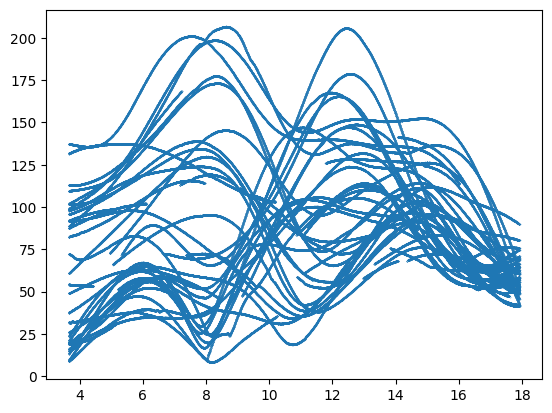

In [443]:
plt.scatter(dat_mvn_crater[:,2], Bmag, marker='.', s=0.1)
# plt.scatter(dat_mvn_crater[:,1], dat_mvn_crater[:,2], marker='.', s=0.1)

'''NOTE: THIS WILL BE INACCURATE BECAUSE THE LATITUDE RANGE IS INCREDIBLE SMALL -- IF WE EXPAND IT, IT'S STILL NOT GOOD BC WE'RE USING ALL TRACK DATA INSTEAD OF THE TRACKS THAT PASS THROUGH THE CRATER'''

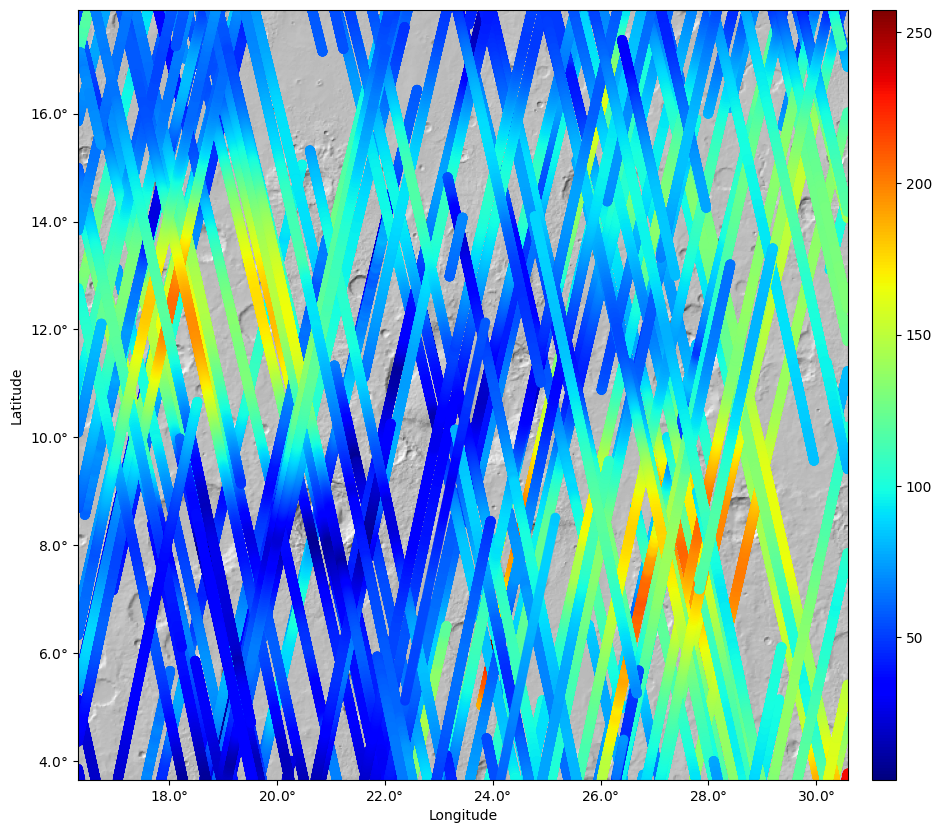

In [448]:
import pooch

import numpy as np
import matplotlib.pyplot as plt
import PIL

from redplanet import utils



figsize = (12,10)
overlay = True
__filepath_mola = ''
transparency_mola = 0.9




lon_left, lon_right = lon_bounds
lat_bottom, lat_top = lat_bounds


'''plotting'''
fig = plt.figure(figsize=figsize)
ax = plt.axes()



'''mola overlay'''
if overlay:

    # global __filepath_mola

    if __filepath_mola == '':
        logger = pooch.get_logger()
        logger.disabled = True

        __filepath_mola = pooch.retrieve(
            fname      = 'Mars_HRSC_MOLA_BlendShade_Global_200mp_v2_resized-7.tif',
            url        = r'https://drive.google.com/file/d/1i278DaeaFCtY19vREbE35OIm4aFRKXiB/view?usp=sharing',
            known_hash = 'sha256:93d32f9b404b7eda1bb8b05caa989e55b219ac19a005d720800ecfe6e2b0bb6c',
            path       = utils.getPath(pooch.os_cache('redplanet'), 'Maps'),
            downloader = utils.download_gdrive_file
        )
        
        logger.disabled = False


    PIL.Image.MAX_IMAGE_PIXELS = 116159282 + 1 # get around PIL's "DecompressionBombError: Image size (-n- pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack." error

    mola = PIL.Image.open(__filepath_mola)

    width, height = mola.size

    left = ( (lon_left+180) / 360 ) * width
    right = ( (lon_right+180) / 360 ) * width
    top = ( (-lat_top+90) / 180 ) * height          # lat values are strange because PIL has (0,0) at the top left. don't think too hard about it, this works.
    bottom = ( (-lat_bottom+90) / 180 ) * height

    mola = mola.crop((left, top, right, bottom))

    im_mola = ax.imshow(mola, cmap='gray', extent=[lon_left, lon_right, lat_bottom, lat_top], alpha=transparency_mola)

    # im_dat = ax.imshow(dat[::-1], cmap=colormap, extent=[lon_left, lon_right, lat_bottom, lat_top], alpha=transparency_data)
# else:
    # im_dat = ax.imshow(dat[::-1], cmap=colormap, extent=[lon_left, lon_right, lat_bottom, lat_top])







im_mag = ax.scatter(dat_mvn_crater[:,1], dat_mvn_crater[:,2], c = Bmag, cmap='jet')























# '''titles'''
# if title is not None:
#     ax.set_title(title, pad=9.0)




ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.xaxis.set_major_formatter('{x}$\degree$')
ax.yaxis.set_major_formatter('{x}$\degree$')





# # (minor aesthetic point: if plotting a global map, ensure that end points are included)
# if lon_bounds == (-180,180):
#     x_spacing = 60
#     ax.set_xticks(np.linspace(lon_left, lon_right, int((lon_right-lon_left)/x_spacing)+1))

# if lat_bounds == (-90,90):
#     y_spacing = 30
#     ax.set_yticks(np.linspace(lat_bottom, lat_top, int((lat_top-lat_bottom)/y_spacing)+1))




# '''x ticks'''
# '''Option 1: Set the spacing between x ticks'''
# # x_spacing = 60
# # ax.set_xticks(np.linspace(lon_left, lon_right, int((lon_right-lon_left)/x_spacing)+1))
# '''Option 2: Set the number of x ticks'''
# # x_ticks = 7
# # ax.set_xticks(np.linspace(lon_left, lon_right, x_ticks))

# '''y ticks'''
# '''Option 1: Set the spacing between y ticks'''
# # y_spacing = 25
# # ax.set_yticks(np.linspace(lat_bottom, lat_top, int((lat_top-lat_bottom)/y_spacing)+1))
# '''Option 2: Set the number of y ticks'''
# # y_ticks = 7
# # ax.set_yticks(np.linspace(lat_bottom, lat_top, y_ticks))



# '''color bar'''
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im_mag, cax=cax)
# if cbar_title is not None:
#     cbar.set_label(f'{cbar_title}', y=0.5)


plt.show()


In [399]:
x = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\data\maven\2_reduced\maven.mag.calibrated-pc-highres__filters=200km,sza90\2015\01\mvn_mag_200km,sza90_2015-01-01.npy'
x = np.load(x)
x = x[0]
print(x[0])
print(np.sqrt(x[4]**2 + x[5]**2 + x[6]**2))

83.138772326
22.342267118625184


In [401]:
7*1024 / (360/5 * 180/5)

2.765432098765432

---
# testing Mag class

In [419]:
from redplanet import Mag

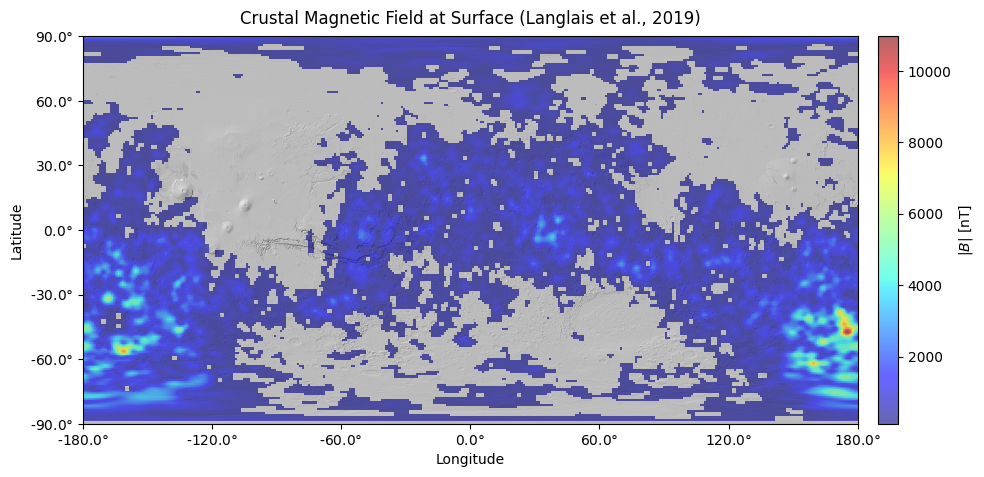

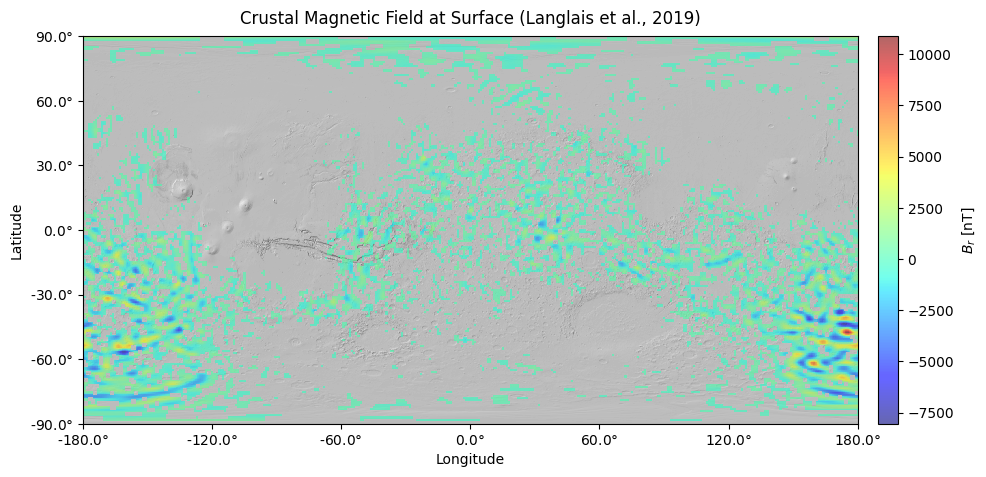

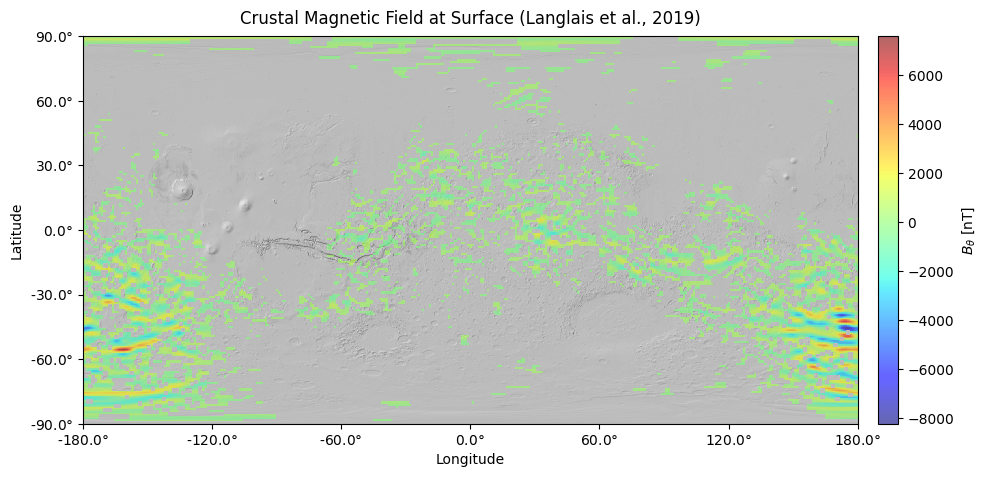

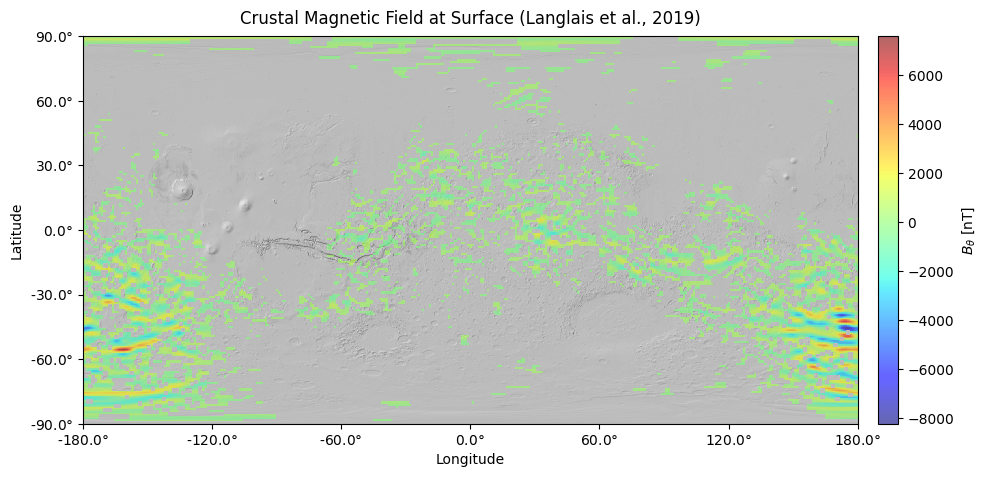

In [385]:
Mag.visualize('Bmag', overlay=True)
Mag.visualize('Br'  , overlay=True)
Mag.visualize('Blon', overlay=True)
Mag.visualize('Blon', overlay=True)

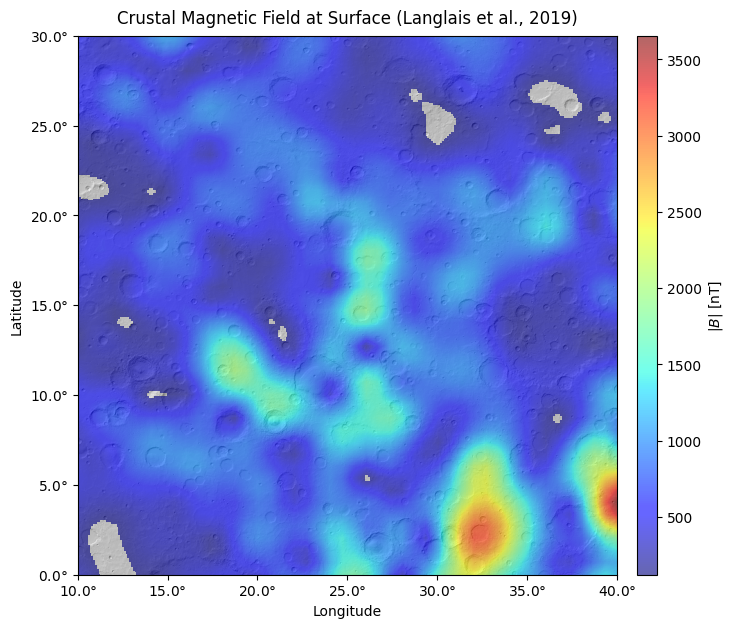

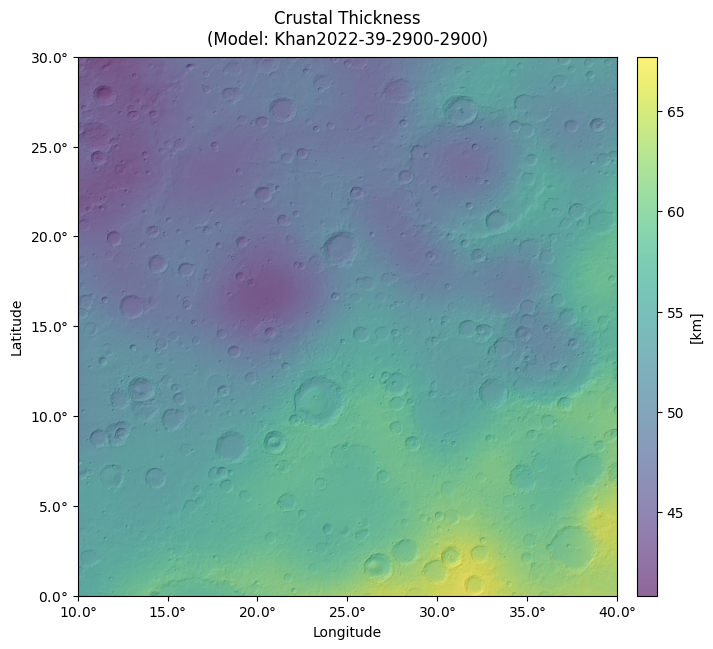

In [386]:
from redplanet import Crust
Mag.visualize('Bmag', overlay=True, lon_bounds=(10,40), lat_bounds=(0,30), grid_spacing=0.1)
Crust.visualize('thick', overlay=True, lon_bounds=(10,40), lat_bounds=(0,30), grid_spacing=0.1)

luju's map looks like bottom right, his is probably B at 200km altitude

<p align="center">
  <a href="https://files.catbox.moe/b9f6hq.png">
    <img width="800" src="https://files.catbox.moe/b9f6hq.png">
  </a>
</p>



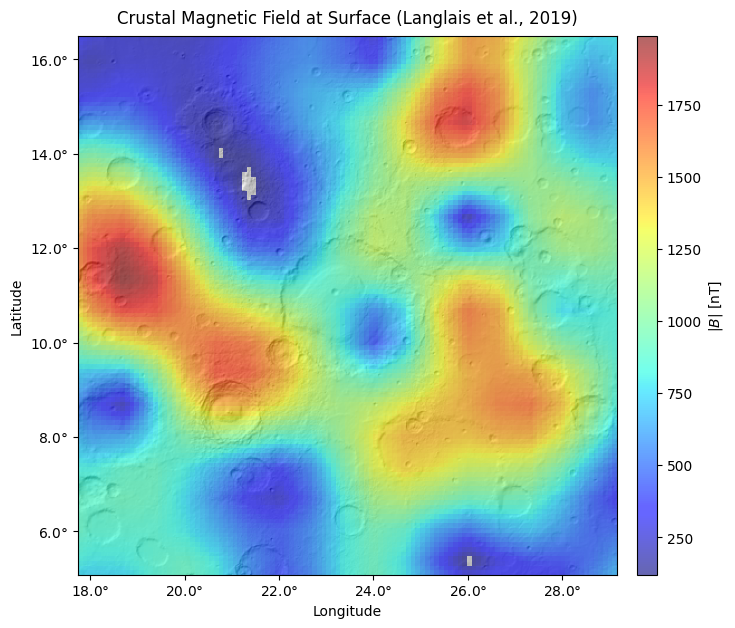

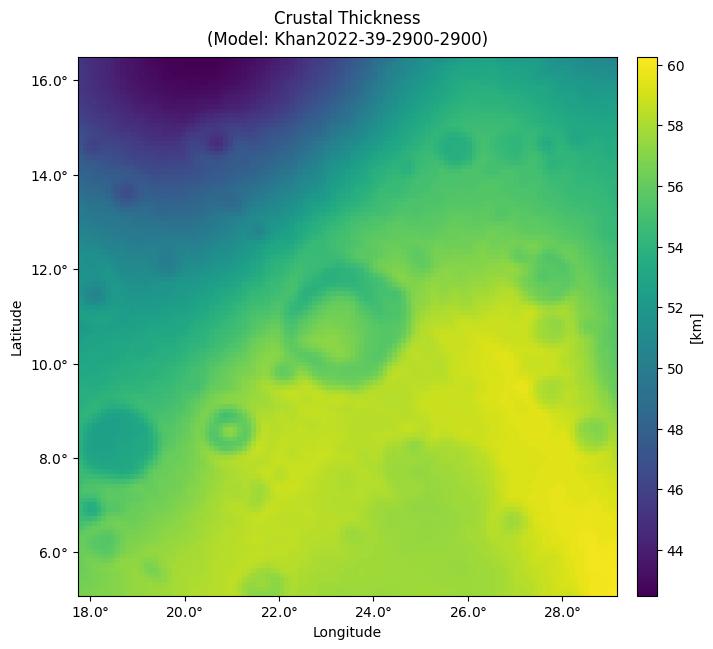

In [422]:
''' visualize henry crater'''
from redplanet import Crust
from redplanet import Craters
from redplanet import utils

thiscrater = Craters.get('henry')
lon, lat, rad = thiscrater['lon'], thiscrater['lat'], utils.km2theta(thiscrater['diameter_km']/2)
scaling = 4
lon_bounds = (lon-rad*scaling, lon+rad*scaling)
lat_bounds = (lat-rad*scaling, lat+rad*scaling)

Mag.visualize('Bmag', overlay=True, lon_bounds=lon_bounds, lat_bounds=lat_bounds, grid_spacing=0.1)
Crust.visualize('thick', overlay=False, lon_bounds=lon_bounds, lat_bounds=lat_bounds, grid_spacing=0.1)